## 1. Setup and Data Loading

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from lordcapulet.data_structures.databank import DataBank
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.objective import ScalarizedPosteriorTransform

# Import our modular components
from gp_model import create_gp_model, train_gp_model, evaluate_model, print_kernel_diagnostics
from acquisition import compute_total_preference, AnalyticCustomPreference
from optimizer import optimize_acquisition, create_bounds_tensor

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Configuration
DATA_CONFIG = {
    # "json_file": "FeO_scan_data_extractor_redone.json",
    "json_file": "UO2_scan_data_extractor_so_n_converted.json",
    "train_test_ratio": 0.1,
    "include_electron_number": False,
    "include_moment": False,
}

# Physics Mean Configuration
MEAN_CONFIG = {
    "type": "VectorizedPhysicsMean",  # Options: "VectorizedPhysicsMean", None
    # Priors for mean function parameters (also used for initialization)
    "J_prior_mean": 0.2,
    "J_prior_std": 0.1,
    # "J_lin_prior_mean": 0.5,
    # "J_lin_prior_std": 0.02,
    "U_prior_mean": 3.0,
    "U_prior_std": 0.2,
}

# Kernel Configuration
KERNEL_CONFIG = {
    # Local kernels (per atom)
    "local": {
        "matern": {
            "enabled": True,
            "nu": 2.5,
            "outputscale_prior": {"mean": 2, "std": 0.2},
        },
    },
    # Non-local kernels (between atom pairs)
    "nonlocal": {
        # "heisenberg": {
        #     "enabled": False,
        #     "outputscale_prior": {"mean": 0.02, "std": 0.002},
        # },
        # "kugel_khomskii": {
        #     "enabled": False,
        #     "outputscale_prior": {"mean": 0.02, "std": 0.002},
        # },
        "residual": {
            "enabled": True,
            "outputscale_prior": {"mean": 0.05, "std": 0.01},
        },
    },
    # Apply spin-flip invariance to all kernels
    "spin_flip_invariant": True,
} # here we kind of need to understand if we can extract the priors from the training data itself, even though they do not 
# really destroy the model too much if they are a bit off

# Optimization Configuration
OPTIMIZATION_CONFIG = {
    "method": "adam",
    "num_restarts": 20,
    "raw_samples": 1048,
    "num_steps": 150,
    "learning_rate": 0.01,
    "use_best_train": False,
    "use_random_train": True,
}

# GP Training Configuration
TRAINING_CONFIG = {
    # Method options:
    # - "fit_gpytorch_mll": Default L-BFGS-B optimizer (recommended)
    # - "sgd": Custom SGD/Adam training loop (DISABLED - issues with Standardize)
    # - "two_stage": Train mean then kernel (DISABLED - issues with Standardize)
    "method": "fit_gpytorch_mll",
    # "method": "sgd",
    # "method": "two_stage",
    
    # SGD configuration (only used if method="sgd")
    "sgd": {
        "epochs": 500,
        "lr": 0.005,
        "optimizer": "adam",  # "sgd" or "adam"
        "print_every": 20,
        # "freeze_kernel": True,  # If True, only train mean parameters, freeze kernel
    },
    
    # Two-stage training configuration (only used if method="two_stage")
    "two_stage": {
        # Stage 1: Train mean function with kernel frozen
        "stage1_epochs": 300,
        "stage1_lr": 0.01,
        "stage1_print_every": 50,
        
        # Stage 2: Train kernel/likelihood with mean frozen
        "stage2_epochs": 500,
        "stage2_lr": 0.002,
        "stage2_print_every": 20,
    },
}

print(f"Running on device: {DEVICE}")


Running on device: cuda


In [2]:
# Load data
databank = DataBank.from_json(
    DATA_CONFIG["json_file"],
    only_converged=True,
    include_electron_number=DATA_CONFIG["include_electron_number"],
    include_moment=DATA_CONFIG["include_moment"],
)

print(f"Loaded {len(databank)} calculations")

# Get available atoms
atoms = databank.atom_ids
print(f"Available atoms: {atoms}")

# get some energies
print(databank.energies.mean())

Loaded 720 calculations
Available atoms: ['1', '2', '3', '4']
-59737.756759766446


In [3]:
# Prepare training data
x_data = databank.to_pytorch(atom_ids=atoms, spins=['up', 'down'], include_energies=False, device=DEVICE)
energies = torch.tensor([rec['energy'] for rec in databank._records], dtype=torch.float32, device=DEVICE)

# Train/test split
num_data = x_data.shape[0]
num_train = int(num_data * DATA_CONFIG["train_test_ratio"])
perm = torch.randperm(num_data)
x_data = x_data[perm]
energies = energies[perm]

x_train = x_data[:num_train]
y_train = energies[:num_train]
x_test = x_data[num_train:]
y_test = energies[num_train:]

print(f"Training data: {x_train.shape[0]} points")
print(f"Test data: {x_test.shape[0]} points")

Training data: 72 points
Test data: 648 points


In [4]:
# Create bounds for optimization
bounds = create_bounds_tensor(databank, atoms, DEVICE)
print(f"Bounds tensor shape: {bounds.shape}")

Bounds tensor shape: torch.Size([2, 224])


## 2. Create and Train GP Model

In [5]:
# Create the GP model
model = create_gp_model(
    train_X=x_train,
    train_Y=y_train.unsqueeze(-1),
    databank=databank,
    atom_ids=atoms,
    mean_config=MEAN_CONFIG,
    kernel_config=KERNEL_CONFIG,
    device=DEVICE
)


/home/carta_a/Documents/Local_calculations/aiida-LordCapulet/lordcapulet/functions/proposal_modes/Bayesian/gp_model.py:62: InputDataWarning: The model inputs are of type torch.float32. It is strongly recommended to use double precision in BoTorch, as this improves both precision and stability and can help avoid numerical errors. See https://github.com/meta-pytorch/botorch/discussions/1444
  model = SingleTaskGP(


In [6]:
# Train the model
try:
    model = train_gp_model(model, x_train, y_train.unsqueeze(-1), TRAINING_CONFIG)
    print("\nGP model training complete")
except (ValueError, RuntimeError) as e:
    print(f"\nWarning: Training encountered issues: {e}")
    print("This can happen with very small training sets. The model may still be usable.")
    print("Consider increasing train_test_ratio or using a simpler kernel configuration or a smaller learning rate.")


GP model training complete


In [7]:
# Print learned physics parameters
if hasattr(model.mean_module, 'J'):
    print("\n--- Learned Physics Parameters ---")
    print(f"J: {model.mean_module.J.item():.4f}")
    # print(f"J_lin: {model.mean_module.J_lin.item():.4f}")
    print(f"U: {model.mean_module.U.item():.4f}")
    print(f"Constant offset: {model.mean_module.constant.item():.4f} eV")


--- Learned Physics Parameters ---
J: 0.5137
U: 2.4842
Constant offset: -5.5599 eV


In [8]:
# Print kernel diagnostics
print_kernel_diagnostics(model)


KERNEL TYPE                    | VARIANCE (Outputscale)   
LOCAL: Texture (Matern)        | 1.90952                  
LOCAL: Texture (Matern)        | 1.88814                  
LOCAL: Texture (Matern)        | 1.89078                  
LOCAL: Texture (Matern)        | 1.88800                  
NON-LOCAL: Residuals (Mat x Mat) | 0.04415                  
NON-LOCAL: Residuals (Mat x Mat) | 0.04422                  
NON-LOCAL: Residuals (Mat x Mat) | 0.04426                  
NON-LOCAL: Residuals (Mat x Mat) | 0.04455                  
NON-LOCAL: Residuals (Mat x Mat) | 0.04457                  
NON-LOCAL: Residuals (Mat x Mat) | 0.04465                  



## 3. Evaluate Model Performance

In [9]:
# Evaluate on test set
results = evaluate_model(model, x_test, y_test)

print("\n--- Model Performance on Test Set ---")
print(f"R² score: {results['r2']:.4f}")
print(f"RMSE: {results['rmse']:.4f} eV")


--- Model Performance on Test Set ---
R² score: 0.8944
RMSE: 0.1751 eV


In [10]:
# Diagnostic: Check mean function contribution vs kernel
with torch.no_grad():
    # Get mean function predictions
    mean_pred = model.mean_module(x_test)
    
    # Get full model predictions
    full_pred = model(x_test).mean
    
    print("--- Diagnostic: Mean vs Kernel Contributions ---")
    print(f"True energy range: [{y_test.min().item():.2f}, {y_test.max().item():.2f}] eV")
    print(f"Mean function range: [{mean_pred.min().item():.2f}, {mean_pred.max().item():.2f}] eV")
    print(f"Full model range: [{full_pred.min().item():.2f}, {full_pred.max().item():.2f}] eV")
    print(f"\nMean function std: {mean_pred.std().item():.4f} eV")
    print(f"True data std: {y_test.std().item():.4f} eV")
    print(f"Kernel contribution (residual): {(full_pred - mean_pred).std().item():.4f} eV")
    
    # Check if mean function is just a constant
    mean_variation = (mean_pred.max() - mean_pred.min()).item()
    print(f"\nMean function variation: {mean_variation:.4f} eV")
    print(f"Physics contribution (J, U): ~{mean_variation:.4f} eV")
    print(f"Constant offset: {model.mean_module.constant.item():.2f} eV")

--- Diagnostic: Mean vs Kernel Contributions ---
True energy range: [-59738.60, -59735.87] eV
Mean function range: [-1.10, 3.97] eV
Full model range: [-2.09, 3.68] eV

Mean function std: 1.0119 eV
True data std: 0.5393 eV
Kernel contribution (residual): 0.2140 eV

Mean function variation: 5.0692 eV
Physics contribution (J, U): ~5.0692 eV
Constant offset: -5.56 eV


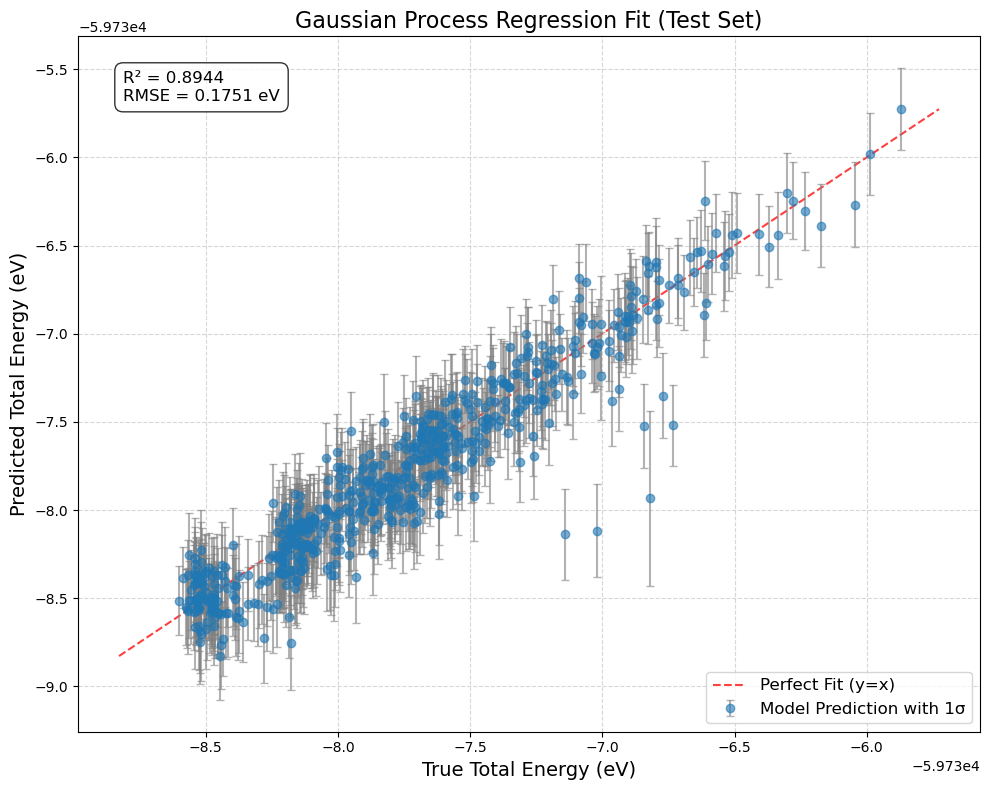

In [11]:
# Visualize predictions vs actual
plt.figure(figsize=(10, 8))

# Plot diagonal line
lims = [
    min(results['y_true'].min(), results['y_pred'].min()),
    max(results['y_true'].max(), results['y_pred'].max()),
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=1, label="Perfect Fit (y=x)")

# Scatter with error bars
plt.errorbar(
    results['y_true'], 
    results['y_pred'], 
    yerr=results['y_std'],
    fmt='o', 
    alpha=0.6, 
    ecolor='gray', 
    capsize=3,
    zorder=2,
    label="Model Prediction with 1σ"
)

plt.xlabel("True Total Energy (eV)", fontsize=14)
plt.ylabel("Predicted Total Energy (eV)", fontsize=14)
plt.title("Gaussian Process Regression Fit (Test Set)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Add metrics to plot
text_str = f"R² = {results['r2']:.4f}\nRMSE = {results['rmse']:.4f} eV"
plt.text(
    0.05, 0.95, text_str,
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8)
)

plt.tight_layout()
plt.show()

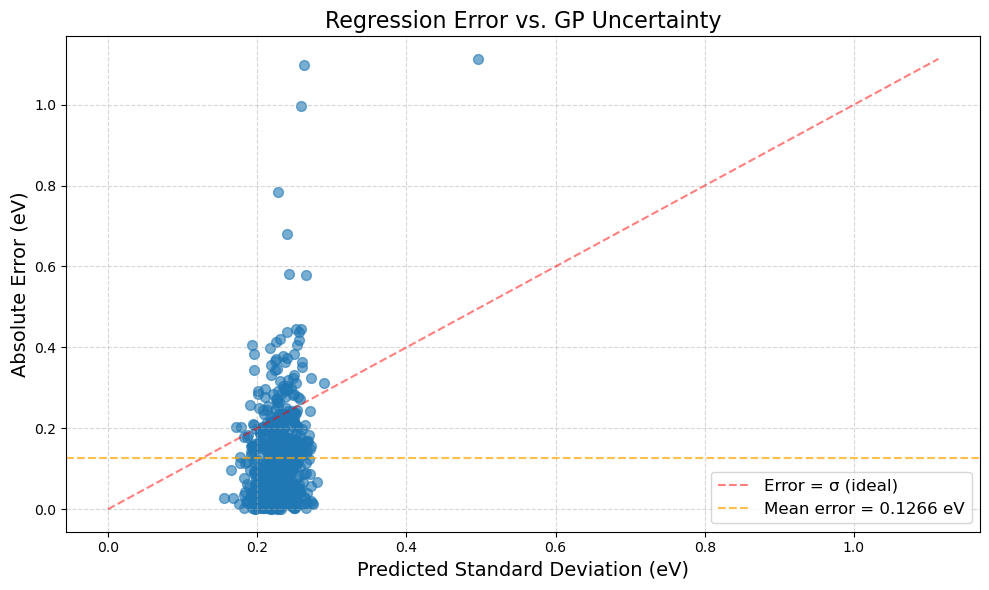


Correlation between uncertainty and error: 0.291
Mean absolute error: 0.1266 eV
Mean predicted std: 0.2284 eV


In [12]:
# Plot error vs standard deviation
plt.figure(figsize=(10, 6))

# one would exprec the unertainty to correlate with the error, but it does not seem to be the case here
# look into calibrating uncertainty (should this be done at the level of the priors or as a post-processing step?

# Calculate absolute errors
errors = np.abs(results['y_true'] - results['y_pred'])

# Scatter plot
plt.scatter(results['y_std'], errors, alpha=0.6, s=50)

plt.xlabel("Predicted Standard Deviation (eV)", fontsize=14)
plt.ylabel("Absolute Error (eV)", fontsize=14)
plt.title("Regression Error vs. GP Uncertainty", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)

# Add diagonal reference line (ideal: error = std)
max_val = max(results['y_std'].max(), errors.max())
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5, label="Error = σ (ideal)")

# Add horizontal line at mean error
mean_error = errors.mean()
plt.axhline(mean_error, color='orange', linestyle='--', alpha=0.7, label=f"Mean error = {mean_error:.4f} eV")

plt.legend(fontsize=12)
plt.tight_layout()
# plt.xlim(0.05, 0.16)
plt.show()

# Print correlation statistics
correlation = np.corrcoef(results['y_std'], errors)[0, 1]
print(f"\nCorrelation between uncertainty and error: {correlation:.3f}")
print(f"Mean absolute error: {errors.mean():.4f} eV")
print(f"Mean predicted std: {results['y_std'].mean():.4f} eV")




## 4. Optimize Acquisition Function

In [13]:
# Create base acquisition function (LCB for minimization)
minimize_transform = ScalarizedPosteriorTransform(weights=torch.tensor([-1.0]))
lcb_energy_acqf = UpperConfidenceBound(
    model=model,
    beta=0.2, 
    posterior_transform=minimize_transform,
    maximize=True
)

In [14]:
# Create acquisition function with physics preferences
# Acquisition Function Configuration
ACQUISITION_CONFIG = {
    "type": "LCB",  # Options: "LCB", "EI", "UCB"
    "beta": 0.5,  # LCB/UCB exploration parameter
    # Physics constraints
    "use_preference": True,
    "trace_target": 2.6,
    "trace_sigma": 0.3,
    # Principal minor constraint
    "use_minor_preference": False,  # Disabled - k=2000 is too strict, all candidates get 0 preference
    "eigenvalue_k": 2000.0,  # Stiffness for minor constraint (only used if enabled)
}





if ACQUISITION_CONFIG["use_preference"]:
    # Create preference function wrapper
    pref_func_wrapper = partial(
        compute_total_preference,
        databank=databank,
        atom_ids=atoms,
        trace_target=ACQUISITION_CONFIG["trace_target"],
        trace_sigma=ACQUISITION_CONFIG["trace_sigma"],
        use_minor_preference=ACQUISITION_CONFIG["use_minor_preference"],
        eig_k=ACQUISITION_CONFIG["eigenvalue_k"]
    )
    
    acqf_final = AnalyticCustomPreference(
        model=model,
        base_acqf=lcb_energy_acqf,
        compute_preference_func=pref_func_wrapper
    )
else:
    acqf_final = lcb_energy_acqf

print("Acquisition function created")


Acquisition function created


In [15]:
# Reload the acquisition module to pick up changes
import importlib
import acquisition
importlib.reload(acquisition)
from acquisition import compute_total_preference, AnalyticCustomPreference

# Recreate the acquisition function with the reloaded module
if ACQUISITION_CONFIG["use_preference"]:
    pref_func_wrapper = partial(
        compute_total_preference,
        databank=databank,
        atom_ids=atoms,
        trace_target=ACQUISITION_CONFIG["trace_target"],
        trace_sigma=ACQUISITION_CONFIG["trace_sigma"],
        use_minor_preference=ACQUISITION_CONFIG["use_minor_preference"],
        eig_k=ACQUISITION_CONFIG["eigenvalue_k"]
    )
    
    acqf_final = AnalyticCustomPreference(
        model=model,
        base_acqf=lcb_energy_acqf,
        compute_preference_func=pref_func_wrapper
    )
else:
    acqf_final = lcb_energy_acqf

print("Acquisition function recreated with updated code")

Acquisition function recreated with updated code


In [17]:
import torch
# Prepare initial guess (optional)
# Optimization Configuration
OPTIMIZATION_CONFIG = {
    "method": "adam",  # Options: "adam", "lbfgs" (extensible for particle swarm, etc.)
    "num_restarts": 20,
    "raw_samples": 1048,
    "num_steps": 150,
    "learning_rate": 0.01,
    # Initial condition strategy (choose one):
    "init_strategy": "patchwork",  # Options: "best_train", "patchwork", None
    # "best_train": Use i-th best training point for i-th candidate
    # "patchwork": Creative mixing of atoms from different training points with spin flips
    # None: Let BoTorch auto-generate initial conditions
}



initial_guess = None
if OPTIMIZATION_CONFIG["init_strategy"] == "best_train":
    min_idx = torch.argmin(y_train)
    best_x_so_far = x_train[min_idx]
    initial_guess = best_x_so_far.unsqueeze(0).unsqueeze(0)
    print(f"Using best training point (index {min_idx}) as initial guess")
elif OPTIMIZATION_CONFIG["init_strategy"] == "patchwork":
    # initial_guess = create_patchwork_guess(databank, x_train, atoms, DEVICE)
    print("Using patchwork initial guess (mixed atoms with spin flips)")
else:
    print("No initial guess - BoTorch will auto-generate")

Using patchwork initial guess (mixed atoms with spin flips)


In [18]:
# Diagnostic: Test acquisition function on training points
print("=== Acquisition Function Diagnostics ===\n")

# Test on best training point
min_idx = torch.argmin(y_train)
best_train_x = x_train[min_idx].unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, num_features]
best_train_energy = y_train[min_idx].item()

with torch.no_grad():
    # Evaluate base LCB acquisition
    base_acqf_value = lcb_energy_acqf(best_train_x)
    print(f"Best training point (energy={best_train_energy:.4f} eV):")
    print(f"  Base LCB acquisition value: {base_acqf_value.item():.4f}")
    
    # Evaluate final acquisition (with preferences)
    final_acqf_value = acqf_final(best_train_x)
    print(f"  Final acquisition value (with preferences): {final_acqf_value.item():.4f}")
    
    # DETAILED preference debugging
    if hasattr(acqf_final, 'compute_pref'):
        pref_score = acqf_final.compute_pref(best_train_x.squeeze(1))
        print(f"  Preference score: {pref_score.item():.6e}")
        
        # Manually compute preference components to debug
        print("\n  DETAILED Preference Breakdown:")
        best_occ = databank.from_pytorch(best_train_x.squeeze(0), atom_ids=atoms, spins=['up', 'down'])[0]
        
        trace_pref_product = 1.0
        minor_pref_product = 1.0
        
        for atom_id in atoms:
            up_mat_np = best_occ.get_occupation_matrix(atom_id, 'up')
            down_mat_np = best_occ.get_occupation_matrix(atom_id, 'down')
            
            up_mat = torch.tensor(up_mat_np, device=best_train_x.device, dtype=best_train_x.dtype)
            down_mat = torch.tensor(down_mat_np, device=best_train_x.device, dtype=best_train_x.dtype)
            
            # Trace preference
            trace = torch.trace(up_mat) + torch.trace(down_mat)
            trace_diff = (trace - ACQUISITION_CONFIG['trace_target'])**2
            trace_pref = torch.exp(-trace_diff / (2 * ACQUISITION_CONFIG['trace_sigma']**2))
            trace_pref_product *= trace_pref.item()
            
            # Minor preference (only if enabled)
            if ACQUISITION_CONFIG['use_minor_preference']:
                from acquisition import compute_minor_preference_offdiag_only
                minor_pref_up = compute_minor_preference_offdiag_only(up_mat, k=ACQUISITION_CONFIG['eigenvalue_k'])
                minor_pref_down = compute_minor_preference_offdiag_only(down_mat, k=ACQUISITION_CONFIG['eigenvalue_k'])
                minor_pref_product *= minor_pref_up.item() * minor_pref_down.item()
                print(f"    {atom_id}: trace={trace.item():.3f}, trace_pref={trace_pref.item():.6e}")
                print(f"           minor_pref_up={minor_pref_up.item():.6e}, minor_pref_down={minor_pref_down.item():.6e}")
            else:
                print(f"    {atom_id}: trace={trace.item():.3f}, trace_pref={trace_pref.item():.6e}")
                print(f"           minor_pref: DISABLED")
        
        print(f"\n  Total trace preference product: {trace_pref_product:.6e}")
        if ACQUISITION_CONFIG['use_minor_preference']:
            print(f"  Total minor preference product: {minor_pref_product:.6e}")
            print(f"  Combined (trace × minor): {trace_pref_product * minor_pref_product:.6e}")
        else:
            print(f"  Total minor preference: DISABLED")
            print(f"  Final preference (trace only): {trace_pref_product:.6e}")
    
    print()

print("\n" + "="*60)
if ACQUISITION_CONFIG['use_minor_preference']:
    print("Minor constraint ENABLED (k={})".format(ACQUISITION_CONFIG['eigenvalue_k']))
    print("  If minor_pref is ~0, reduce k or disable it")
else:
    print("Minor constraint DISABLED")
    print("  Only trace preference is active")
print("="*60 + "\n")


=== Acquisition Function Diagnostics ===

Best training point (energy=-59738.6016 eV):
  Base LCB acquisition value: 59738.6172
  Final acquisition value (with preferences): 54683.4766
  Preference score: 9.153790e-01

  DETAILED Preference Breakdown:
    1: trace=2.640, trace_pref=9.911504e-01
           minor_pref: DISABLED
    2: trace=2.673, trace_pref=9.708282e-01
           minor_pref: DISABLED
    3: trace=2.669, trace_pref=9.738967e-01
           minor_pref: DISABLED
    4: trace=2.665, trace_pref=9.768011e-01
           minor_pref: DISABLED

  Total trace preference product: 9.153791e-01
  Total minor preference: DISABLED
  Final preference (trace only): 9.153791e-01


Minor constraint DISABLED
  Only trace preference is active



In [19]:
test_matrix = databank.get_record(0)['occ_data']

test_tensor = torch.tensor(test_matrix["1"]['occupation_matrix']['up'])
print(test_tensor)

# now apply the minor preference function

from acquisition import compute_minor_preference_offdiag_only


# add violation
# test_tensor[0, 1] = 0.9
# test_tensor[1, 0] = 0.9


minor_pref_value = compute_minor_preference_offdiag_only(test_tensor, k=5000.0)
print(f"Minor preference value for test matrix: {minor_pref_value.item():.6e}")

tensor([[ 0.0480,  0.0000, -0.0000,  0.0030, -0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0360, -0.0000,  0.0000,  0.0000, -0.0030, -0.0000],
        [-0.0000, -0.0000,  0.0350, -0.0000, -0.0000, -0.0000,  0.0040],
        [ 0.0030,  0.0000, -0.0000,  0.0330, -0.0000, -0.0000, -0.0000],
        [-0.0000,  0.0000, -0.0000, -0.0000,  0.1090, -0.0000, -0.0000],
        [ 0.0000, -0.0030, -0.0000, -0.0000, -0.0000,  0.0340,  0.0000],
        [ 0.0000, -0.0000,  0.0040, -0.0000, -0.0000,  0.0000,  0.0380]])
Minor preference value for test matrix: 9.770498e-01


In [22]:
def create_patchwork_guess(databank, x_train, atoms, device):
    """
    Create a diverse initial guess by mixing atoms from different training points.
    
    Strategy:
    1. For each atom, randomly select a training point
    2. With 50% probability, flip spins (swap up/down matrices)
    3. If atoms are of the same species, optionally permute them
    
    Args:
        databank: DataBank with atom information
        x_train: Training data tensor [N, features]
        atoms: List of atom IDs
        device: torch device
    
    Returns:
        Patchwork guess tensor [1, 1, features]
    """
    import random
    from copy import deepcopy
    
    # Step 1: Create patchwork by selecting random training points for each atom
    # Start with a copy of the first training point's OccupationMatrixData
    patchwork_occ = databank.from_pytorch(x_train[0].unsqueeze(0), atom_ids=atoms, spins=['up', 'down'])[0]
    
    # Deep copy the internal data to avoid modifying the original
    patchwork_data = deepcopy(patchwork_occ.data)
    
    source_indices = {}  # Track which training point each atom came from
    
    for atom_id in atoms:
        # Randomly select a training point for this atom
        source_idx = random.randint(0, len(x_train) - 1)
        source_indices[atom_id] = source_idx
        
        # Extract occupation matrices from this training point
        source_occ = databank.from_pytorch(x_train[source_idx].unsqueeze(0), atom_ids=atoms, spins=['up', 'down'])[0]
        up_mat = source_occ.get_occupation_matrix(atom_id, 'up')
        down_mat = source_occ.get_occupation_matrix(atom_id, 'down')
        
        # Step 2: With 50% probability, flip spins
        if random.random() < 0.5:
            up_mat, down_mat = down_mat, up_mat  # Swap
        
        # Update the patchwork data for this atom
        patchwork_data[atom_id]['occupation_matrix']['up'] = up_mat
        patchwork_data[atom_id]['occupation_matrix']['down'] = down_mat
    
    # Step 3: If atoms are same species, optionally permute
    # Group atoms by species (assuming atom IDs like "Fe1", "Fe2" have same species)
    species_groups = {}
    for atom_id in atoms:
        # Get species from the patchwork data
        species = patchwork_data[atom_id]['specie']
        if species not in species_groups:
            species_groups[species] = []
        species_groups[species].append(atom_id)
    
    # For each species with multiple atoms, decide whether to permute
    for species, atom_group in species_groups.items():
        if len(atom_group) > 1 and random.random() < 0.5:
            # Permute matrices among atoms of same species
            shuffled_group = atom_group.copy()
            random.shuffle(shuffled_group)
            
            # Create temporary storage of occupation matrices
            temp_matrices = {}
            for atom in atom_group:
                temp_matrices[atom] = {
                    'up': patchwork_data[atom]['occupation_matrix']['up'],
                    'down': patchwork_data[atom]['occupation_matrix']['down']
                }
            
            # Apply permutation
            for orig_atom, new_atom in zip(atom_group, shuffled_group):
                patchwork_data[orig_atom]['occupation_matrix'] = temp_matrices[new_atom]
    
    # Create new OccupationMatrixData from the modified data
    from lordcapulet.data_structures.occupation_matrix import OccupationMatrixData
    patchwork_occ_final = OccupationMatrixData(patchwork_data)
    
    # Convert to tensor using the new method
    patchwork_tensor = databank.to_pytorch_single_matrix(
        patchwork_occ_final, 
        atom_ids=atoms, 
        spins=['up', 'down'], 
        device=device
    )
    
    # Reshape to [1, 1, features] for optimize_acqf
    return patchwork_tensor.unsqueeze(0).unsqueeze(0)


# Test the patchwork function
print("Testing patchwork initialization...")
test_guess = create_patchwork_guess(databank, x_train, atoms, DEVICE)
print(f"Patchwork guess shape: {test_guess.shape}")
print("Patchwork initialization ready!")

Testing patchwork initialization...
Patchwork guess shape: torch.Size([1, 1, 224])
Patchwork initialization ready!


In [23]:
# Optimize acquisition function to get multiple candidates
# For custom acquisition functions with physics constraints, sequential optimization is better
from botorch.optim import optimize_acqf

NUM_CANDIDATES = 10

print(f"Finding {NUM_CANDIDATES} candidates sequentially...")
print(f"Initialization strategy: {OPTIMIZATION_CONFIG['init_strategy']}\n")

candidates_list = []
acqf_values_list = []

for i in range(NUM_CANDIDATES):
    print(f"  Candidate {i+1}/{NUM_CANDIDATES}...", end=" ")
    
    # Prepare initial guess based on strategy
    if OPTIMIZATION_CONFIG["init_strategy"] == "best_train":
        # Use i-th best training point
        if i < len(y_train):
            sorted_energies, sorted_indices = torch.sort(y_train)
            best_idx = sorted_indices[i]
            initial_guess = x_train[best_idx].unsqueeze(0).unsqueeze(0)
        else:
            initial_guess = None
    elif OPTIMIZATION_CONFIG["init_strategy"] == "patchwork":
        # Create patchwork guess with mixed atoms and spin flips
        initial_guess = create_patchwork_guess(databank, x_train, atoms, DEVICE)
    else:
        # Let BoTorch auto-generate
        initial_guess = None
    
    # Optimize for a single candidate
    candidate, acqf_value = optimize_acqf(
        acq_function=acqf_final,
        bounds=bounds,
        q=1,  # One candidate at a time
        num_restarts=10,  # Fewer restarts for speed
        raw_samples=512,  # Fewer samples for speed
        batch_initial_conditions=initial_guess,
        return_best_only=True,
    )
    
    candidates_list.append(candidate)
    acqf_values_list.append(acqf_value.item())
    print(f"acqf={acqf_value.item():.4f}")

# Stack all candidates
candidates = torch.cat(candidates_list, dim=0)

print(f"\nOptimization complete!")
print(f"Candidates shape: {candidates.shape}")
print(f"Generated {len(candidates_list)} candidates")

Finding 10 candidates sequentially...
Initialization strategy: patchwork

  Candidate 1/10... 

/home/carta_a/anaconda3/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


acqf=55230.9883
  Candidate 2/10... 

/home/carta_a/anaconda3/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


acqf=55411.5352
  Candidate 3/10... 

/home/carta_a/anaconda3/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


acqf=55674.1406
  Candidate 4/10... 

/home/carta_a/anaconda3/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


acqf=46466.4062
  Candidate 5/10... 

/home/carta_a/anaconda3/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


acqf=53761.2930
  Candidate 6/10... 

/home/carta_a/anaconda3/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


acqf=52964.8828
  Candidate 7/10... 

/home/carta_a/anaconda3/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


acqf=53768.2891
  Candidate 8/10... 

/home/carta_a/anaconda3/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


acqf=55064.4531
  Candidate 9/10... 

/home/carta_a/anaconda3/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


acqf=53834.9609
  Candidate 10/10... acqf=55209.7461

Optimization complete!
Candidates shape: torch.Size([10, 224])
Generated 10 candidates
acqf=55209.7461

Optimization complete!
Candidates shape: torch.Size([10, 224])
Generated 10 candidates


/home/carta_a/anaconda3/lib/python3.12/site-packages/botorch/optim/optimize.py:362: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  generated_initial_conditions = opt_inputs.get_ic_generator()(


In [24]:
# Summary of all candidates
print("\n" + "="*80)
print("SUMMARY OF ALL CANDIDATES")
print("="*80)

with torch.no_grad():
    for i, (cand, acqf_val) in enumerate(zip(candidates_list, acqf_values_list)):
        posterior = model.posterior(cand)
        mean_energy = posterior.mean.item()
        std_energy = posterior.variance.sqrt().item()
        print(f"Candidate {i+1:2d}: Acqf={acqf_val:8.4f} | Energy={mean_energy:10.4f} ± {std_energy:.4f} eV")

print("="*80)
print(f"\nBest acquisition value: Candidate {np.argmin(acqf_values_list) + 1}")
print(f"To analyze a specific candidate, set CANDIDATE_INDEX in the cell below\n")



SUMMARY OF ALL CANDIDATES
Candidate  1: Acqf=55230.9883 | Energy=-59738.2383 ± 0.2503 eV
Candidate  2: Acqf=55411.5352 | Energy=-59738.4102 ± 0.2381 eV
Candidate  3: Acqf=55674.1406 | Energy=-59737.7539 ± 0.2297 eV
Candidate  4: Acqf=46466.4062 | Energy=-59736.9414 ± 0.2219 eV
Candidate  5: Acqf=53761.2930 | Energy=-59738.0430 ± 0.1881 eV
Candidate  6: Acqf=52964.8828 | Energy=-59736.9062 ± 0.2202 eV
Candidate  7: Acqf=53768.2891 | Energy=-59737.1875 ± 0.2204 eV
Candidate  8: Acqf=55064.4531 | Energy=-59738.4375 ± 0.2006 eV
Candidate  9: Acqf=53834.9609 | Energy=-59736.8672 ± 0.2229 eV
Candidate 10: Acqf=55209.7461 | Energy=-59738.2031 ± 0.1987 eV

Best acquisition value: Candidate 4
To analyze a specific candidate, set CANDIDATE_INDEX in the cell below



## 5. Analyze Candidates

Select which candidate to analyze in detail:

In [28]:
# ====== SELECT CANDIDATE TO ANALYZE ======
CANDIDATE_INDEX = 0  # Change this to analyze different candidates (0 to NUM_CANDIDATES-1)
# ==========================================

candidate = candidates_list[CANDIDATE_INDEX]
acqf_value = acqf_values_list[CANDIDATE_INDEX]

print(f"=== Analyzing Candidate {CANDIDATE_INDEX + 1}/{NUM_CANDIDATES} ===")
print(f"Acquisition value: {acqf_value:.4f}\n")

# Get predicted energy for candidate
with torch.no_grad():
    posterior = model.posterior(candidate)
    mean = posterior.mean
    stddev = posterior.variance.sqrt()
    
print(f"Expected Energy: {mean.item():.4f} eV ± {stddev.item():.4f} eV")


=== Analyzing Candidate 1/10 ===
Acquisition value: 55230.9883

Expected Energy: -59738.2383 eV ± 0.2503 eV



--- Novelty Analysis ---
Minimum distance to training set: 2.582943
Mean distance to training set: 3.369904
Median distance to training set: 3.403870
Closest training point: index 57 (PK=79841)


/tmp/ipykernel_62213/3320690284.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


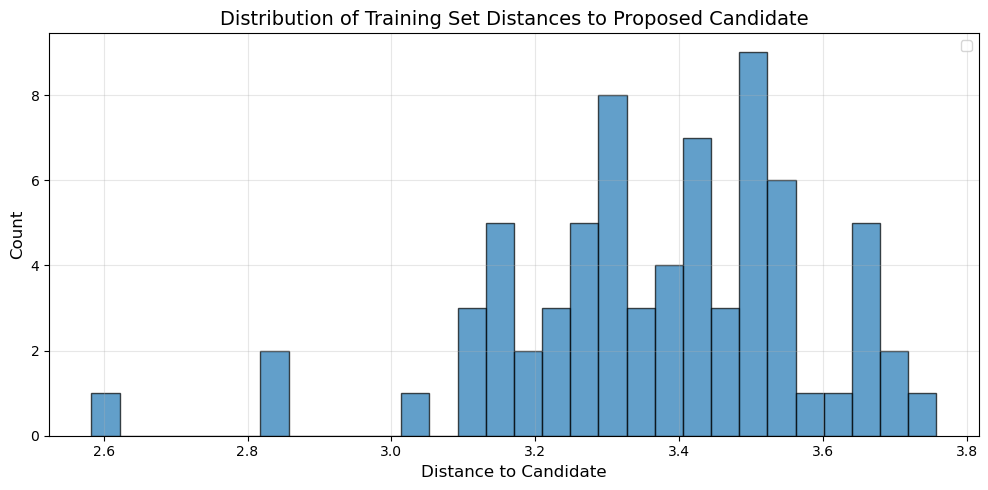

In [29]:
# Compute novelty: distance to training set
print("\n--- Novelty Analysis ---")

# Convert candidate back to OccupationMatrixData
candidate_occ_data = databank.from_pytorch(
    candidate[0].detach().unsqueeze(0), 
    atom_ids=atoms, 
    spins=['up', 'down']
)[0]

# Get the training subset from the permutation
train_indices = perm[:num_train].cpu().numpy()
train_databank = databank[train_indices]

# Compute distances to all training points using DataBank's method
distances_to_train = train_databank.compute_distances(
    reference=candidate_occ_data,
    atom_label=None,  # Compute total distance across all atoms
    spins=['up', 'down']
)

min_distance = distances_to_train.min()
min_idx = distances_to_train.argmin()

print(f"Minimum distance to training set: {min_distance:.6f}")
print(f"Mean distance to training set: {distances_to_train.mean():.6f}")
print(f"Median distance to training set: {np.median(distances_to_train):.6f}")
print(f"Closest training point: index {min_idx} (PK={train_databank.pks[min_idx]})")

# Visualize distance distribution
plt.figure(figsize=(10, 5))
plt.hist(distances_to_train, bins=30, alpha=0.7, edgecolor='black')
# plt.axvline(min_distance, color='red', linestyle='--', linewidth=2, label=f'Candidate distance: {min_distance:.4f}')
plt.xlabel("Distance to Candidate", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Training Set Distances to Proposed Candidate", fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




Atom ID: 1 (Candidate 1/10)

Up Matrix:
[[ 0.087 -0.     0.    -0.126 -0.     0.    -0.   ]
 [-0.     0.053 -0.     0.     0.    -0.006 -0.   ]
 [ 0.    -0.     0.069 -0.    -0.     0.     0.109]
 [-0.126  0.    -0.     0.974 -0.     0.    -0.   ]
 [-0.     0.    -0.    -0.     0.131 -0.    -0.   ]
 [ 0.    -0.006  0.     0.    -0.     0.042  0.   ]
 [-0.    -0.     0.109 -0.    -0.     0.     0.965]]

Down Matrix:
[[ 0.06   0.    -0.     0.004 -0.     0.     0.   ]
 [ 0.     0.039 -0.     0.     0.    -0.002 -0.   ]
 [-0.    -0.     0.044 -0.    -0.    -0.     0.003]
 [ 0.004  0.    -0.     0.032 -0.    -0.    -0.   ]
 [-0.     0.    -0.    -0.     0.109 -0.     0.   ]
 [ 0.    -0.002 -0.    -0.    -0.     0.036  0.   ]
 [ 0.    -0.     0.003 -0.     0.     0.     0.032]]

Trace (Up + Down): 2.673
Eigenvalues Up: [0.039 0.056 0.056 0.069 0.131 0.978 0.992]
Eigenvalues Down: [0.031 0.031 0.035 0.04  0.045 0.061 0.109]


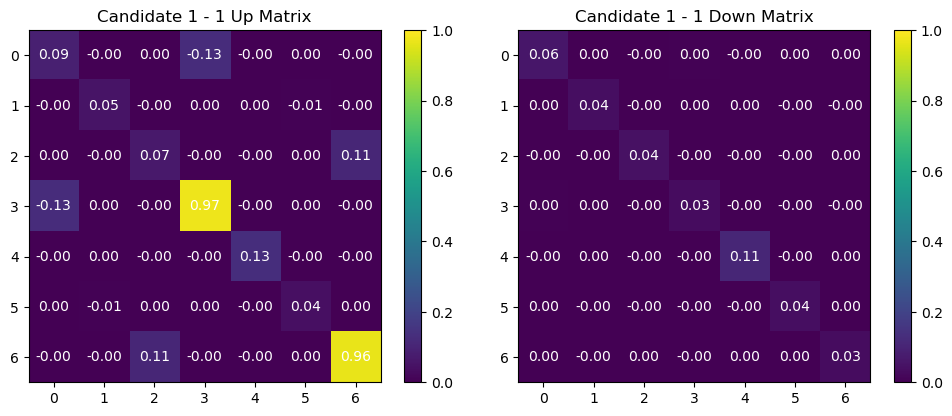


Atom ID: 2 (Candidate 1/10)

Up Matrix:
[[ 0.043  0.    -0.    -0.002 -0.     0.     0.   ]
 [ 0.     0.038 -0.     0.     0.    -0.002 -0.   ]
 [-0.    -0.     0.039 -0.    -0.    -0.     0.005]
 [-0.002  0.    -0.     0.037 -0.    -0.    -0.   ]
 [-0.     0.    -0.    -0.     0.115 -0.    -0.   ]
 [ 0.    -0.002 -0.    -0.    -0.     0.04   0.   ]
 [ 0.    -0.     0.005 -0.    -0.     0.     0.041]]

Down Matrix:
[[ 0.979  0.     0.     0.032  0.    -0.     0.   ]
 [ 0.     0.046  0.     0.     0.    -0.005 -0.   ]
 [ 0.     0.     0.047 -0.    -0.    -0.    -0.032]
 [ 0.032  0.    -0.     0.05  -0.    -0.    -0.   ]
 [ 0.     0.    -0.    -0.     0.142 -0.    -0.   ]
 [-0.    -0.005 -0.    -0.    -0.     0.045  0.   ]
 [ 0.    -0.    -0.032 -0.    -0.     0.     0.982]]

Trace (Up + Down): 2.644
Eigenvalues Up: [0.035 0.036 0.037 0.041 0.044 0.045 0.115]
Eigenvalues Down: [0.04  0.046 0.049 0.051 0.142 0.98  0.983]


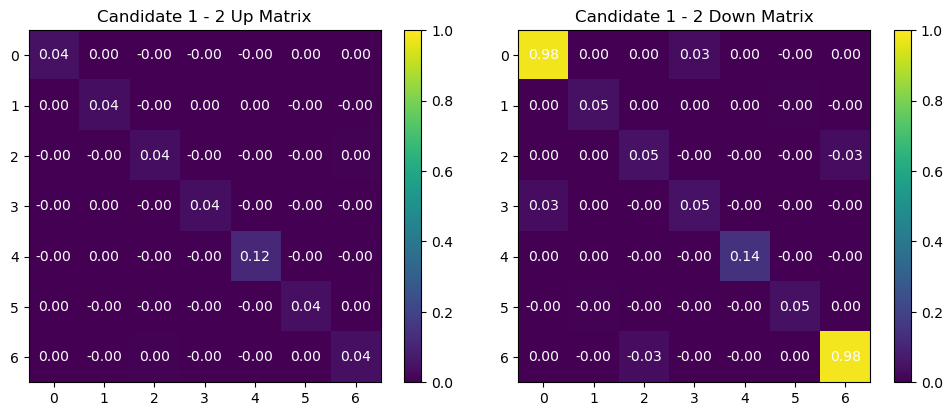


Atom ID: 3 (Candidate 1/10)

Up Matrix:
[[ 0.052  0.    -0.     0.006 -0.     0.     0.   ]
 [ 0.     0.035 -0.     0.     0.    -0.004 -0.   ]
 [-0.    -0.     0.04  -0.    -0.    -0.     0.005]
 [ 0.006  0.    -0.     0.037 -0.    -0.    -0.   ]
 [-0.     0.    -0.    -0.     0.109 -0.    -0.   ]
 [ 0.    -0.004 -0.    -0.    -0.     0.041  0.   ]
 [ 0.    -0.     0.005 -0.    -0.     0.     0.043]]

Down Matrix:
[[ 0.497  0.     0.    -0.466  0.     0.     0.   ]
 [ 0.     0.239 -0.    -0.     0.     0.383 -0.   ]
 [ 0.    -0.     0.051 -0.    -0.    -0.     0.009]
 [-0.466 -0.    -0.     0.545 -0.    -0.    -0.   ]
 [ 0.     0.    -0.    -0.     0.132 -0.    -0.   ]
 [ 0.     0.383 -0.    -0.    -0.     0.797 -0.   ]
 [ 0.    -0.     0.009 -0.    -0.    -0.     0.048]]

Trace (Up + Down): 2.666
Eigenvalues Up: [0.033 0.035 0.036 0.043 0.047 0.054 0.109]
Eigenvalues Down: [0.04  0.044 0.054 0.059 0.132 0.988 0.992]


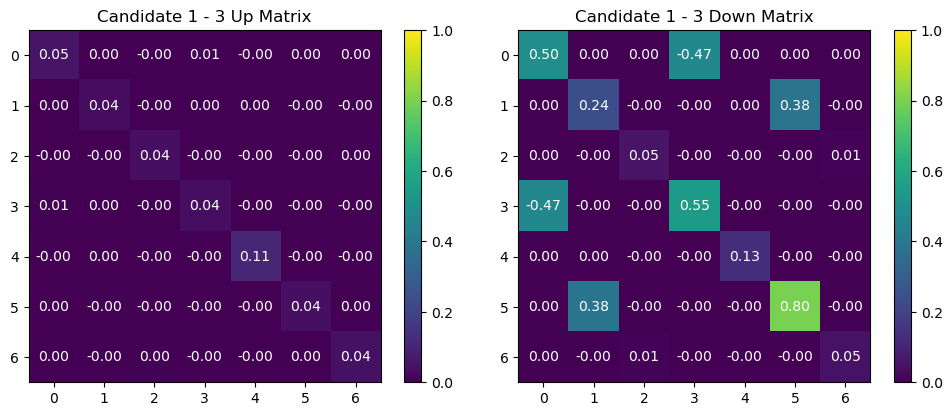


Atom ID: 4 (Candidate 1/10)

Up Matrix:
[[ 0.045  0.    -0.     0.001 -0.     0.    -0.   ]
 [ 0.     0.041 -0.     0.     0.    -0.004 -0.   ]
 [-0.    -0.     0.572 -0.    -0.     0.     0.464]
 [ 0.001  0.    -0.     0.034 -0.    -0.    -0.   ]
 [-0.     0.    -0.    -0.     0.126 -0.    -0.   ]
 [ 0.    -0.004  0.    -0.    -0.     0.042  0.   ]
 [-0.    -0.     0.464 -0.    -0.     0.     0.445]]

Down Matrix:
[[ 0.375 -0.     0.    -0.446  0.    -0.    -0.   ]
 [-0.     0.04  -0.     0.     0.    -0.005 -0.   ]
 [ 0.    -0.     0.041 -0.    -0.    -0.    -0.003]
 [-0.446  0.    -0.     0.664 -0.     0.     0.   ]
 [ 0.     0.    -0.    -0.     0.124 -0.    -0.   ]
 [-0.    -0.005 -0.     0.    -0.     0.048  0.   ]
 [-0.    -0.    -0.003  0.    -0.     0.     0.053]]

Trace (Up + Down): 2.650
Eigenvalues Up: [0.034 0.037 0.04  0.045 0.046 0.126 0.977]
Eigenvalues Down: [0.038 0.04  0.05  0.051 0.054 0.124 0.988]


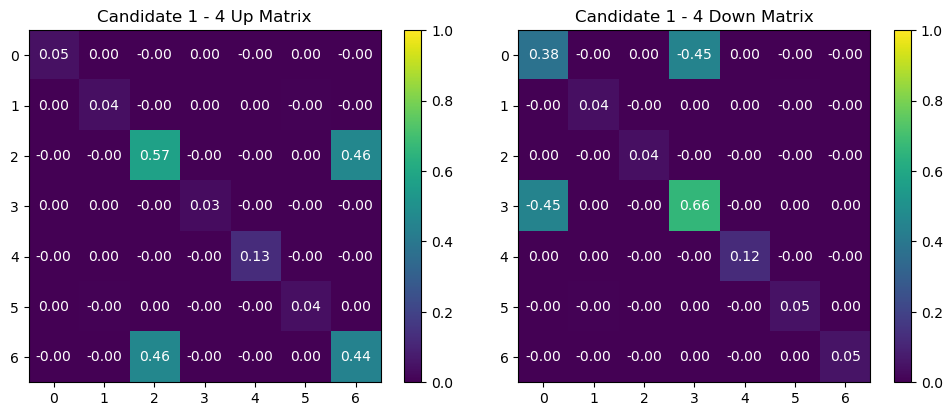

In [30]:
# Unflatten and display occupation matrices for selected candidate
# Detach the candidate from the computation graph before converting
matrices_candidate = databank.from_pytorch(candidate[0].detach().unsqueeze(0), atom_ids=atoms, spins=['up', 'down'])[0]

for atom_id in atoms:
    up_matrix = matrices_candidate.get_occupation_matrix(atom_id, 'up')
    down_matrix = matrices_candidate.get_occupation_matrix(atom_id, 'down')
    
    up_matrix_np = np.array(up_matrix)
    down_matrix_np = np.array(down_matrix)
    
    print(f"\n{'='*60}")
    print(f"Atom ID: {atom_id} (Candidate {CANDIDATE_INDEX + 1}/{NUM_CANDIDATES})")
    print(f"{'='*60}")
    
    print("\nUp Matrix:")
    print(np.round(up_matrix_np, 3))
    
    print("\nDown Matrix:")
    print(np.round(down_matrix_np, 3))
    
    # Compute physical properties
    trace = np.trace(up_matrix_np) + np.trace(down_matrix_np)
    eigvals_up = np.linalg.eigvalsh(up_matrix_np)
    eigvals_down = np.linalg.eigvalsh(down_matrix_np)
    
    print(f"\nTrace (Up + Down): {trace:.3f}")
    print(f"Eigenvalues Up: {np.round(eigvals_up, 3)}")
    print(f"Eigenvalues Down: {np.round(eigvals_down, 3)}")
    
    # Visualize matrices
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    # Up matrix
    im1 = axs[0].imshow(abs(up_matrix_np), cmap='viridis', vmax=1.0, vmin=0.0)
    axs[0].set_title(f'Candidate {CANDIDATE_INDEX + 1} - {atom_id} Up Matrix')
    for i in range(up_matrix_np.shape[0]): 
        for j in range(up_matrix_np.shape[1]):
            axs[0].text(j, i, f"{up_matrix_np[i, j]:.2f}", ha='center', va='center', color='w')
    fig.colorbar(im1, ax=axs[0])
    
    # Down matrix
    im2 = axs[1].imshow(abs(down_matrix_np), cmap='viridis', vmax=1.0, vmin=0.0)
    axs[1].set_title(f'Candidate {CANDIDATE_INDEX + 1} - {atom_id} Down Matrix')
    for i in range(down_matrix_np.shape[0]):   
        for j in range(down_matrix_np.shape[1]):
            axs[1].text(j, i, f"{down_matrix_np[i, j]:.2f}", ha='center', va='center', color='w')
    fig.colorbar(im2, ax=axs[1])
    
    plt.tight_layout()
    plt.show()


## Summary

This notebook demonstrates the complete workflow:

1. **Data Loading**: Load occupation matrices from DataBank
2. **Model Creation**: Build GP with physics-based mean and flexible kernel
3. **Training**: Train using simple or two-stage approach
4. **Evaluation**: Assess model performance on test data
5. **Optimization**: Find next candidate using constrained acquisition function
6. **Analysis**: Visualize and validate the proposed candidate

All settings can be controlled through `config.py` for easy experimentation.